In [1]:
import pandas as pd

def process_hourly_data(header_lines, file_path, output_value_name):
    """
    Calculate the daily average values and retain three decimal places. 
    Parameters:
    header_lines (int): The number of header lines to skip
    file_path (str): The path of the data file
    output_value_name (str): The name of the value column in the output DataFrame 
    Return:
    pd.DataFrame: Processed daily average DataFrame, including columns of year/month/day and the specified value column name
    """

    df = pd.read_csv(file_path, skiprows=header_lines, header=0, sep='\s+')

    df_cleaned = df[df['value'] != -999.99]
    
    daily_avg = (
        df_cleaned.groupby(['year', 'month', 'day'])['value']
        .mean()
        .round(3)
        .reset_index()
        .rename(columns={'value': output_value_name}) 
    )
    
    return daily_avg

def process_hourly_data2(header_lines, file_path, output_value_name):

    df = pd.read_csv(file_path, skiprows=header_lines, header=0, sep='\s+')

    df.columns = ['year', 'month', 'day', 'hour', 'minute', 'value', 'std']

    df = df.drop(columns=['minute', 'std'])
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df_cleaned = df[~df['value'].isna()]

    daily_avg = (
        df_cleaned.groupby(['year', 'month', 'day'])['value']
        .mean()
        .round(3)
        .reset_index()
        .rename(columns={'value': output_value_name}) 
    )
    
    return daily_avg

<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:30: SyntaxWarning: invalid escape sequence '\s'
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_83176/4166275134.py:14: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, skiprows=header_lines, header=0, sep='\s+')
/var/folders/dr/6j37tcfd6lg9zbmw4fsj75nr0000gn/T/ipykernel_83176/4166275134.py:30: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, skiprows=header_lines, header=0, sep='\s+')


In [2]:
co2_result = process_hourly_data(164, 'co2_brw_surface-insitu_1_ccgg_HourlyData.txt', 'co2')
ch4_result = process_hourly_data(153, 'ch4_brw_surface-insitu_1_ccgg_HourlyData.txt', 'ch4')
n2o_result = process_hourly_data2(40,'brw_N2O_All.dat.txt', 'n2o')
sf6_result = process_hourly_data2(40,'brw_SF6_All.dat.txt', 'sf6')

In [3]:
merged_df = pd.merge(co2_result, ch4_result, 
                     on=['year', 'month', 'day'], 
                     how='outer') 

merged_df = pd.merge(merged_df, n2o_result,
                     on=['year', 'month', 'day'],
                     how='outer')

merged_df = pd.merge(merged_df, sf6_result,
                     on=['year', 'month', 'day'],
                     how='outer')

merged_df = merged_df.sort_values(['year', 'month', 'day']).reset_index(drop=True)

print(merged_df.head())

   year  month  day      co2  ch4  n2o  sf6
0  1973      7   24  325.555  NaN  NaN  NaN
1  1973      7   25  325.453  NaN  NaN  NaN
2  1973      7   26  326.150  NaN  NaN  NaN
3  1973      7   27  325.434  NaN  NaN  NaN
4  1973      7   28  324.445  NaN  NaN  NaN


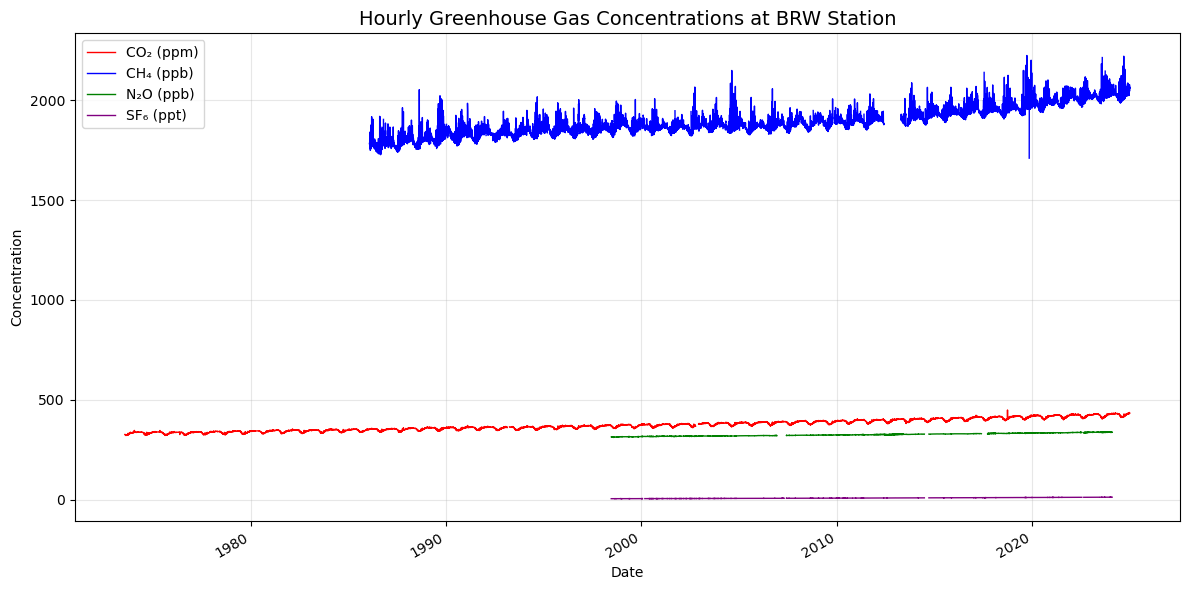

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

merged_df['date'] = pd.to_datetime(merged_df[['year', 'month', 'day']])

merged_df = merged_df.sort_values('date').reset_index(drop=True)
plt.figure(figsize=(12, 6))

plt.plot(merged_df['date'], merged_df['co2'], label='CO₂ (ppm)', color='red', linewidth=1)
plt.plot(merged_df['date'], merged_df['ch4'], label='CH₄ (ppb)', color='blue', linewidth=1)
plt.plot(merged_df['date'], merged_df['n2o'], label='N₂O (ppb)', color='green', linewidth=1)
plt.plot(merged_df['date'], merged_df['sf6'], label='SF₆ (ppt)', color='purple', linewidth=1)

plt.legend(loc='upper left')
plt.title('Hourly Greenhouse Gas Concentrations at BRW Station', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Concentration')

plt.gcf().autofmt_xdate()

plt.grid(alpha=0.3)  
plt.tight_layout() 
plt.show()

In [5]:
import pandas as pd
import numpy as np

def gradient_fill_na(df):
    """
    Intermediate consecutive NaN values: Fill with linear interpolation of the adjacent values.
    Leading/trailing NaN values: Keep as they are.
    """
    filled_df = df.copy()
    cols_to_fill = [col for col in filled_df.columns 
                   if col not in ['year', 'month', 'day']]
    
    for col in cols_to_fill:
        notna_indices = filled_df.index[filled_df[col].notna()]
        
        for i in range(len(notna_indices)-1):
            start = notna_indices[i]
            end = notna_indices[i+1]
            
            if end - start > 1:
                prev_val = filled_df.at[start, col]
                next_val = filled_df.at[end, col]
                
                n_gaps = end - start - 1
                fill_values = np.linspace(prev_val, next_val, n_gaps + 2)[1:-1]
                
                filled_df.loc[start+1:end-1, col] = fill_values
                
    return filled_df

In [6]:
test_data = {
    'year': [2020]*12,
    'month': [1]*12,
    'day': range(1, 13),
    'value': [np.nan, np.nan, np.nan, 1, 2, 3, np.nan, np.nan, np.nan, 7, 8, 9]
}

test_df = pd.DataFrame(test_data)
filled_df = gradient_fill_na(test_df)
print(filled_df)

    year  month  day  value
0   2020      1    1    NaN
1   2020      1    2    NaN
2   2020      1    3    NaN
3   2020      1    4    1.0
4   2020      1    5    2.0
5   2020      1    6    3.0
6   2020      1    7    4.0
7   2020      1    8    5.0
8   2020      1    9    6.0
9   2020      1   10    7.0
10  2020      1   11    8.0
11  2020      1   12    9.0


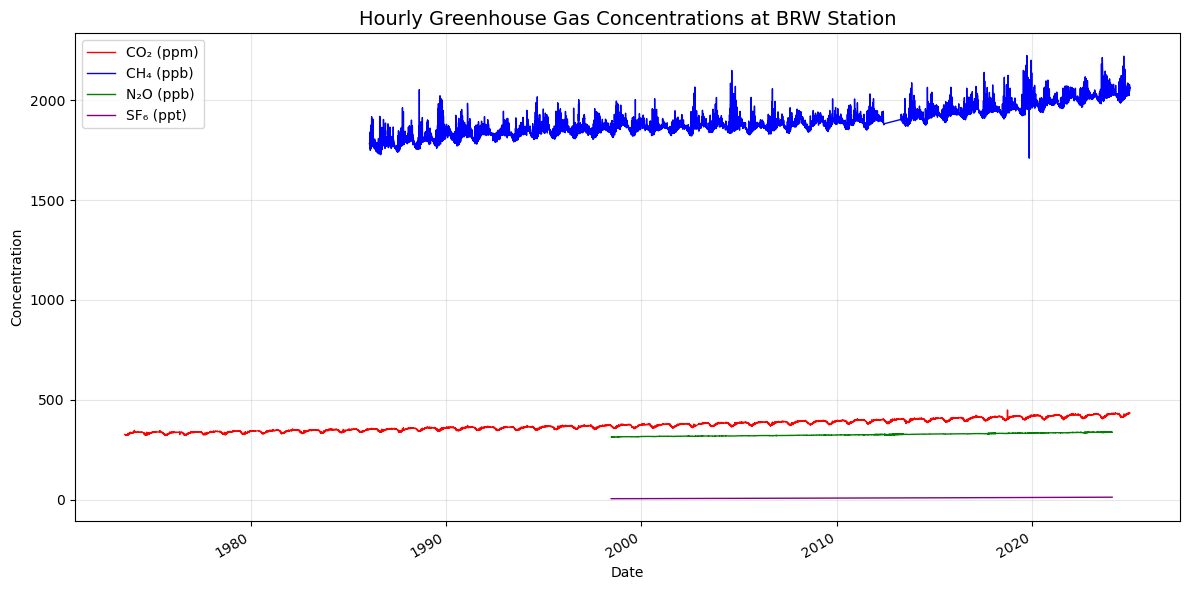

In [7]:
merged_df = gradient_fill_na(merged_df)
# 假设 merged_df 是之前合并后的 DataFrame
merged_df['date'] = pd.to_datetime(merged_df[['year', 'month', 'day']])


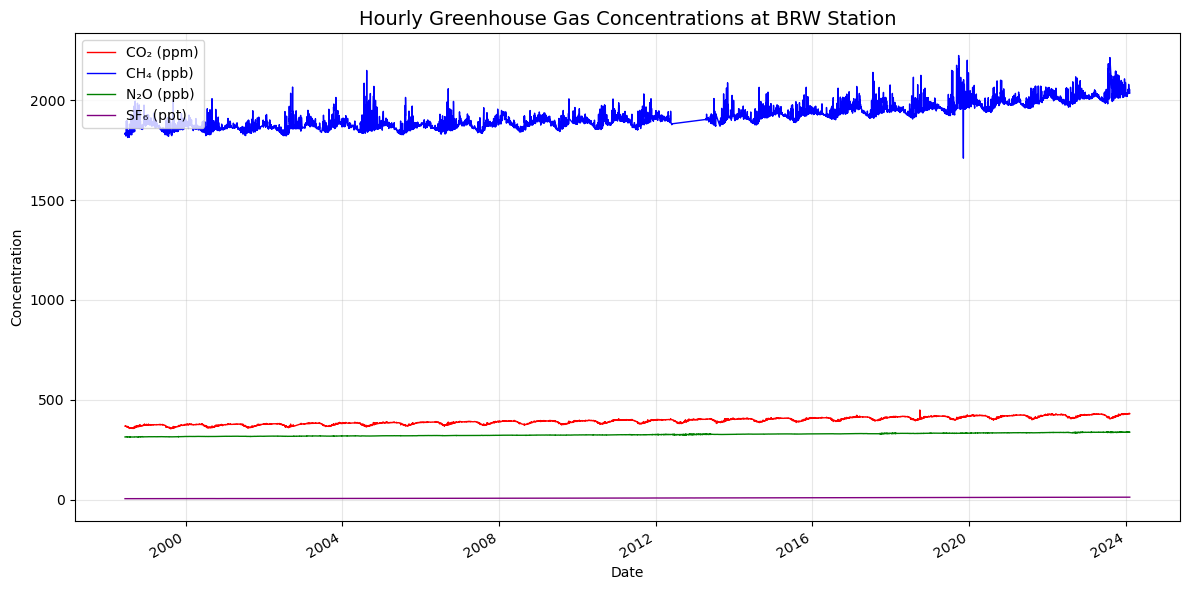

In [9]:
merged_df = merged_df.dropna()
merged_df = gradient_fill_na(merged_df)
merged_df['date'] = pd.to_datetime(merged_df[['year', 'month', 'day']])

merged_df = merged_df.sort_values('date').reset_index(drop=True)
plt.figure(figsize=(12, 6))

plt.plot(merged_df['date'], merged_df['co2'], label='CO₂ (ppm)', color='red', linewidth=1)
plt.plot(merged_df['date'], merged_df['ch4'], label='CH₄ (ppb)', color='blue', linewidth=1)
plt.plot(merged_df['date'], merged_df['n2o'], label='N₂O (ppb)', color='green', linewidth=1)
plt.plot(merged_df['date'], merged_df['sf6'], label='SF₆ (ppt)', color='purple', linewidth=1)

plt.legend(loc='upper left')
plt.title('Hourly Greenhouse Gas Concentrations at BRW Station', fontsize=14)
plt.xlabel('Date')
plt.ylabel('Concentration')

plt.gcf().autofmt_xdate()

plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()